In [1]:
pip install pandas matplotlib prophet


##Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import os

##Step - 1: Load Dataset

In [41]:
df = pd.read_csv("/content/Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv")
df['Date'] = pd.to_datetime(df['Date'])
df

<ipython-input-41-a2126140d5b8>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,2024-08-30,16436,10705,225,19026,3925,59.0
1,2023-09-15,15499,10671,267,18421,4519,61.0
2,2021-12-28,1756,2352,0,3775,0,13.0
3,2023-01-11,10536,8347,223,14072,0,48.0
4,2021-09-11,820,612,0,1283,0,11.0
...,...,...,...,...,...,...,...
1913,2023-01-19,11337,8671,262,14881,0,66.0
1914,2023-08-16,16791,11800,387,20936,4684,113.0
1915,2022-01-10,5732,3548,73,6644,0,25.0
1916,2020-05-04,3717,1952,70,4411,131,19.0


##Step - 2: Add usefull columns

In [42]:
df['day_of_week'] = df['Date'].dt.day_name()
service_columns = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
service_columns

['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

##Basic Summary

In [43]:
print("\n📊 BASIC STATS")
print(df[service_columns].describe())


📊 BASIC STATS
        Local Route    Light Rail  Peak Service   Rapid Route       School
count   1918.000000   1918.000000   1918.000000   1918.000000  1918.000000
mean    9891.395203   7195.446298    179.581335  12597.213243  2352.694995
std     6120.715714   3345.616428    156.532738   6720.494557  2494.766306
min        1.000000      0.000000      0.000000      0.000000     0.000000
25%     3044.500000   4463.500000      0.000000   6383.000000     0.000000
50%    11417.000000   7507.000000    193.000000  13106.500000   567.500000
75%    15517.500000  10008.250000    313.750000  17924.750000  4914.000000
max    21070.000000  15154.000000   1029.000000  28678.000000  7255.000000


## Step - 3 : Clean Dataset

In [48]:
# === Step 1: Clean and Sort by Date ===
df.drop_duplicates(subset='Date', keep='first', inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# === Step 2: Handle Missing Values ===
df.ffill(inplace=True)  # Forward fill
df.bfill(inplace=True)  # Backward fill

# === Step 3: Remove Outliers Using IQR ===
service_columns = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
for col in service_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df = df[(df[col] >= lower) & (df[col] <= upper)]


##Insight - 1 : Trend over time

<ipython-input-49-e482eae93172>:8: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


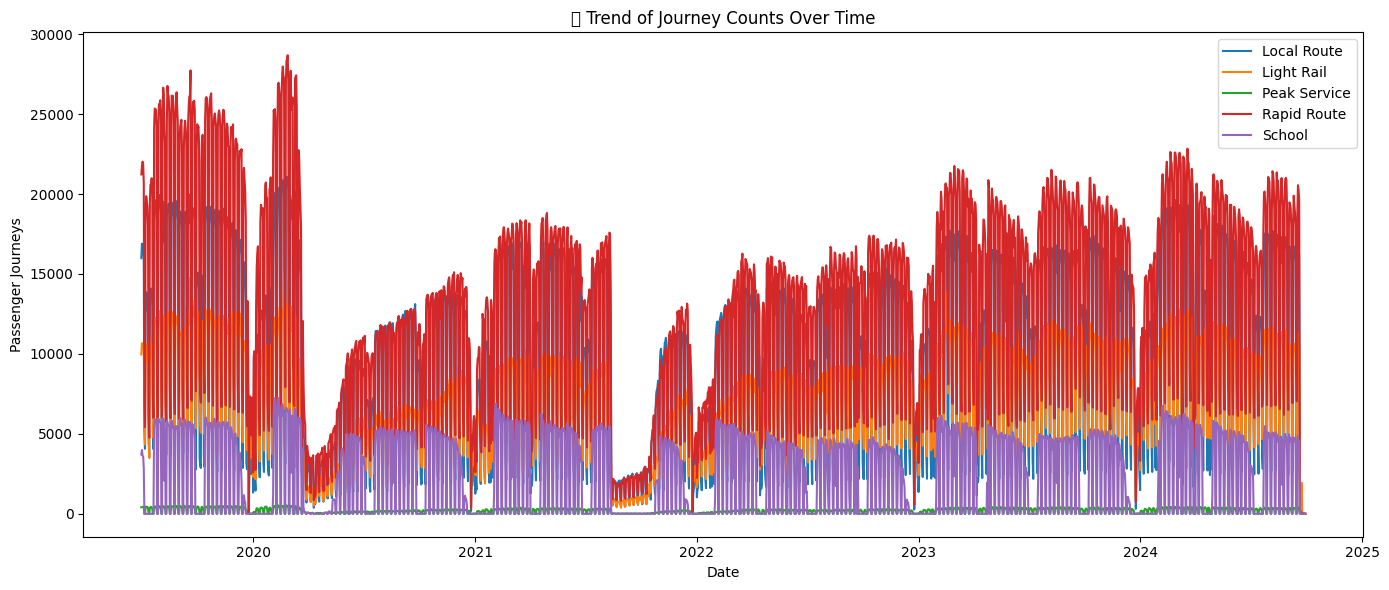

In [49]:
plt.figure(figsize=(14, 6))
for col in service_columns:
    sns.lineplot(data=df, x='Date', y=col, label=col.replace('_', ' ').title())
plt.title("📈 Trend of Journey Counts Over Time")
plt.xlabel("Date")
plt.ylabel("Passenger Journeys")
plt.legend()
plt.tight_layout()
plt.show()

##Insight - 2 : Day-of-week-pattern

<ipython-input-50-9c148a49b9fd>:6: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


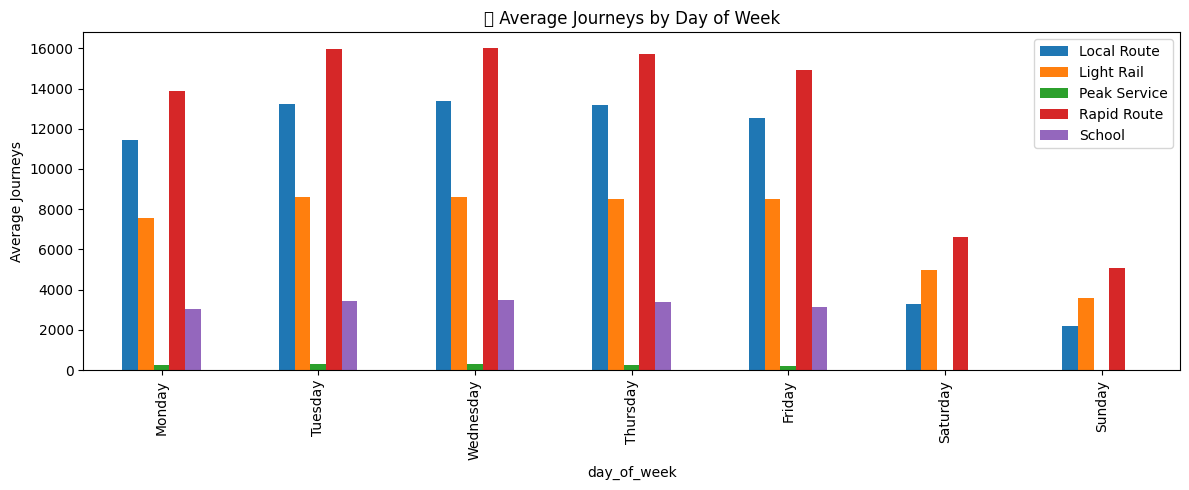

In [50]:
dow_avg = df.groupby('day_of_week')[service_columns].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
dow_avg.plot(kind='bar', figsize=(12, 5), title="📅 Average Journeys by Day of Week")
plt.ylabel("Average Journeys")
plt.tight_layout()
plt.show()

##Insight - 3: Relative share of Each service


📊 % Contribution of Each Service:
Rapid Route     39.104055
Local Route     30.702437
Light Rail      22.335676
School           7.301605
Peak Service     0.556228
dtype: float64


<ipython-input-51-949e00d2bc5a>:9: UserWarning: Glyph 128653 (\N{ONCOMING BUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128653 (\N{ONCOMING BUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


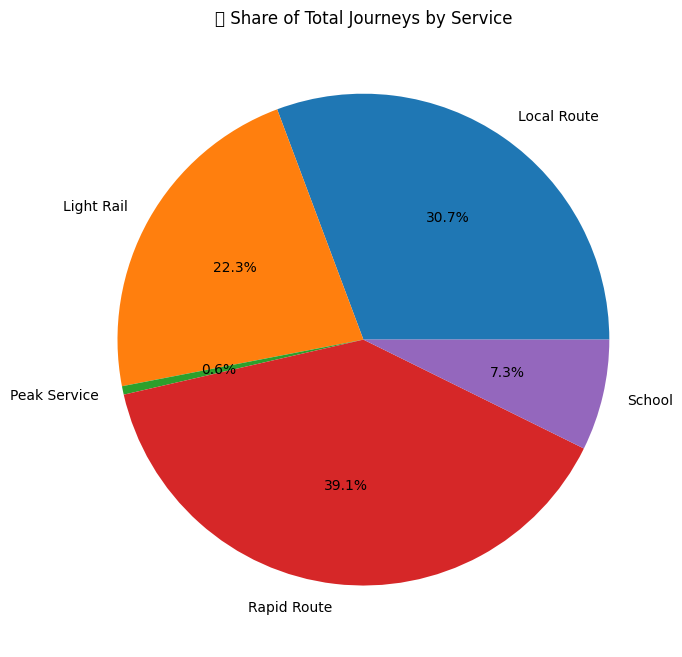

In [51]:
df['total'] = df[service_columns].sum(axis=1)
avg_percent = (df[service_columns].sum() / df['total'].sum()) * 100
print("\n📊 % Contribution of Each Service:")
print(avg_percent.sort_values(ascending=False))

# Pie chart
avg_percent.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 7), title="🚍 Share of Total Journeys by Service")
plt.ylabel('')
plt.tight_layout()
plt.show()

##Insights - 4: Anamoly Detection of Light rail

In [52]:
df['light_rail_diff'] = df['Light Rail'].diff().abs()
threshold = df['light_rail_diff'].mean() + 3 * df['light_rail_diff'].std()
anomalies = df[df['light_rail_diff'] > threshold]
print("\n⚠️ ANOMALIES in Light Rail:")
print(anomalies[['Date', 'Light Rail', 'light_rail_diff']])



⚠️ ANOMALIES in Light Rail:
           Date  Light Rail  light_rail_diff
353  2019-09-21        5740           9049.0
1450 2019-11-04       11601           7853.0
203  2020-02-17       12012           7804.0
97   2020-02-23        6520           8634.0
567  2020-03-10       12442           8043.0
1286 2021-03-15        9384           7681.0
1427 2023-04-07        2347           8038.0
342  2023-11-13       12088           7707.0
1081 2024-03-29        4101           8202.0
1613 2024-09-20        2537           7932.0


## Insight - 5: School Services weekly behaviour

<ipython-input-53-80f714de785f>:6: UserWarning: Glyph 127890 (\N{SCHOOL SATCHEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127890 (\N{SCHOOL SATCHEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


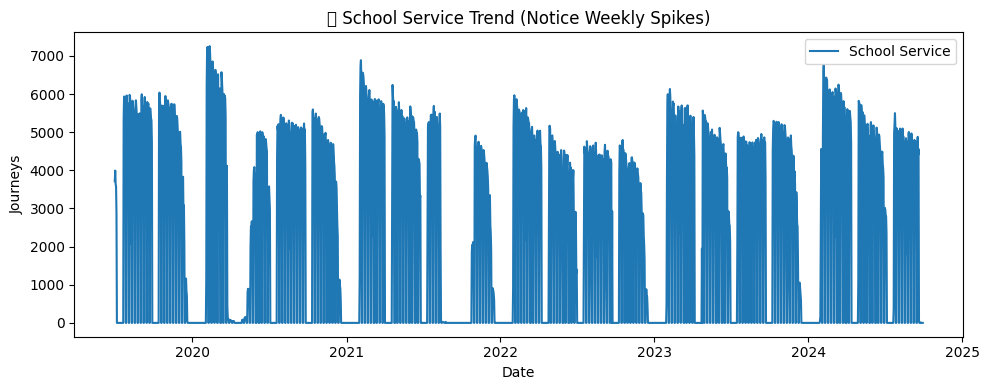

In [53]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x='Date', y='School', label='School Service')
plt.title("🎒 School Service Trend (Notice Weekly Spikes)")
plt.xlabel("Date")
plt.ylabel("Journeys")
plt.tight_layout()
plt.show()

##FORECASTING: 7-Day Forecast for Each Service

In [54]:
forecast_results = {}
output_dir = "forecast_output"
os.makedirs(output_dir, exist_ok=True)

for service in service_columns:
    print(f"\n📈 Forecasting next 7 days for: {service}")
    df_service = df[['Date', service]].rename(columns={'Date': 'ds', service: 'y'}).dropna()


📈 Forecasting next 7 days for: Local Route

📈 Forecasting next 7 days for: Light Rail

📈 Forecasting next 7 days for: Peak Service

📈 Forecasting next 7 days for: Rapid Route

📈 Forecasting next 7 days for: School


  ### Prophet model

In [55]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='additive')
model.fit(df_service)

future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/5w6c_1r0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/n2r_km7h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9136', 'data', 'file=/tmp/tmpydkgb4r9/5w6c_1r0.json', 'init=/tmp/tmpydkgb4r9/n2r_km7h.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_modelqttfh_rm/prophet_model-20250527060554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:05:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:05:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/tku_xcnk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/dpgrokug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30209', 'data', 'file=/tmp/tmpydkgb4r9/tku_xcnk.json', 'init=/tmp/tmpydkgb4r9/dpgrokug.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_model3glu9cou/prophet_model-20250527060557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:05:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Local Route
  Data points available: 1917


06:05:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-56-a15932e6569b>:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


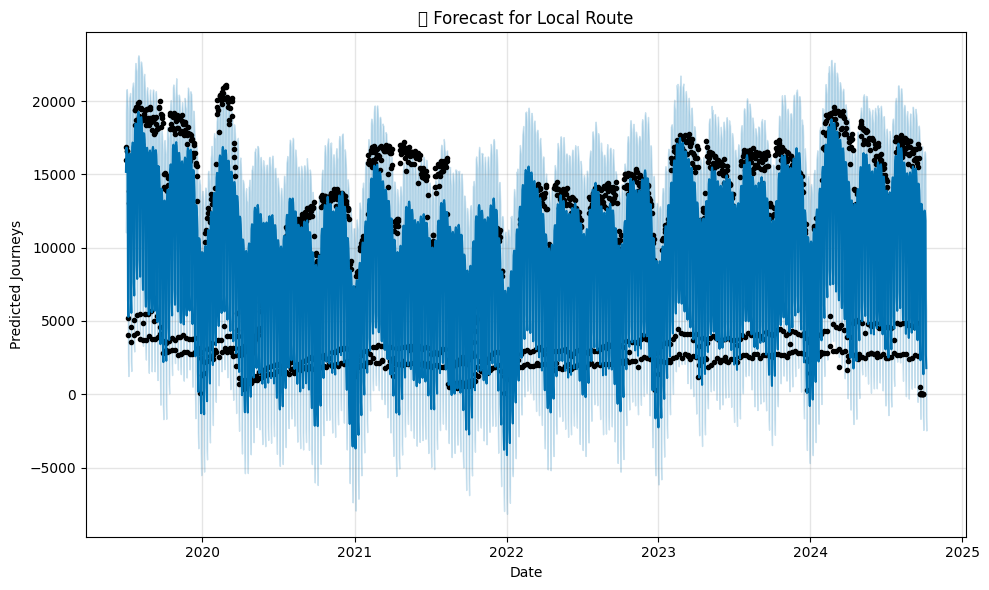

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/5t5d6sh1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/s0gdgvsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2810', 'data', 'file=/tmp/tmpydkgb4r9/5t5d6sh1.json', 'init=/tmp/tmpydkgb4r9/s0gdgvsk.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_model8wxrvhuy/prophet_model-20250527060558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:05:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Light Rail
  Data points available: 1917


06:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-56-a15932e6569b>:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


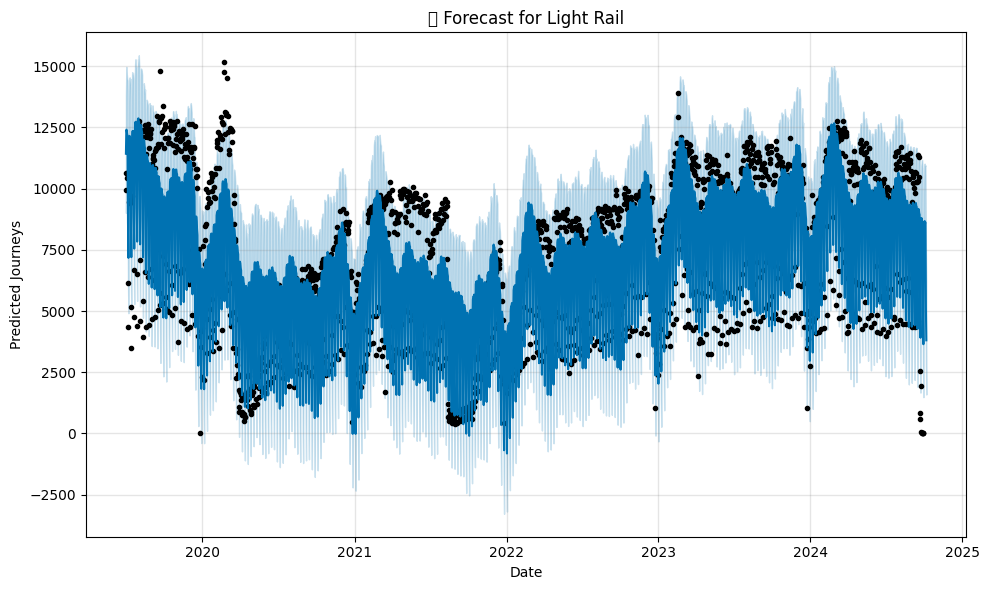

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/ugzhmc7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/ajuypt5y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84665', 'data', 'file=/tmp/tmpydkgb4r9/ugzhmc7v.json', 'init=/tmp/tmpydkgb4r9/ajuypt5y.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_model8tuq7mc4/prophet_model-20250527060600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:06:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Peak Service
  Data points available: 1917


06:06:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-56-a15932e6569b>:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


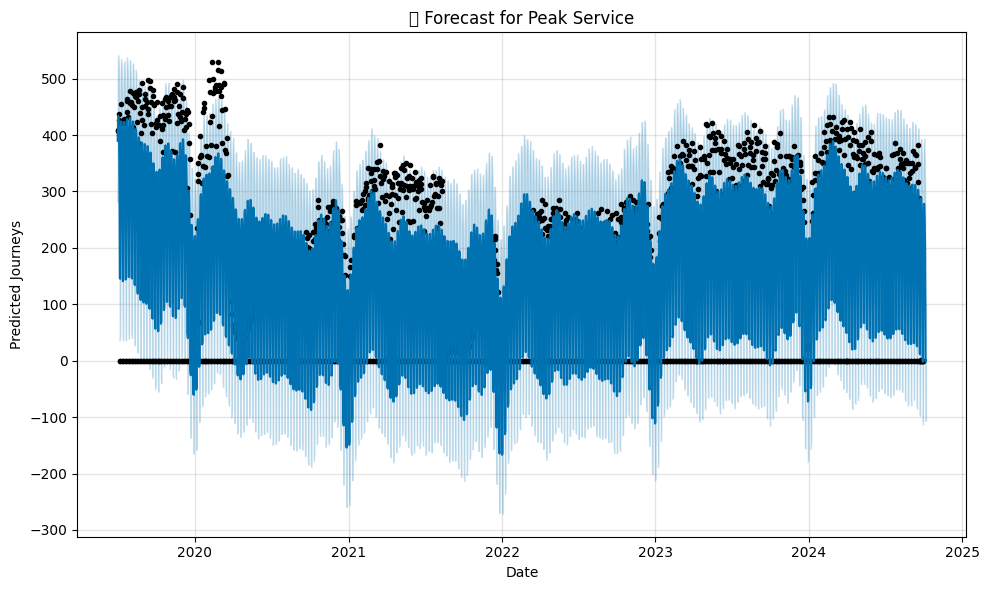

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/qhu661jj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/e_vugz8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37870', 'data', 'file=/tmp/tmpydkgb4r9/qhu661jj.json', 'init=/tmp/tmpydkgb4r9/e_vugz8u.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_modelvtvnt9fc/prophet_model-20250527060601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:06:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Rapid Route
  Data points available: 1917


06:06:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-56-a15932e6569b>:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


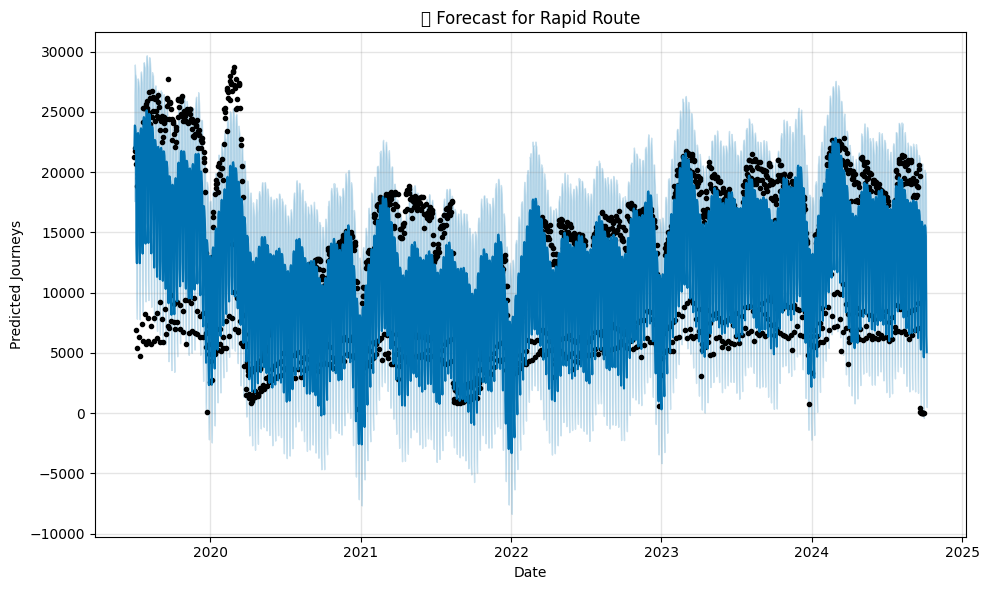

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/x8s4w45b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/fu8idiqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14705', 'data', 'file=/tmp/tmpydkgb4r9/x8s4w45b.json', 'init=/tmp/tmpydkgb4r9/fu8idiqy.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_modelca1t29s1/prophet_model-20250527060602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: School
  Data points available: 1917


06:06:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-56-a15932e6569b>:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


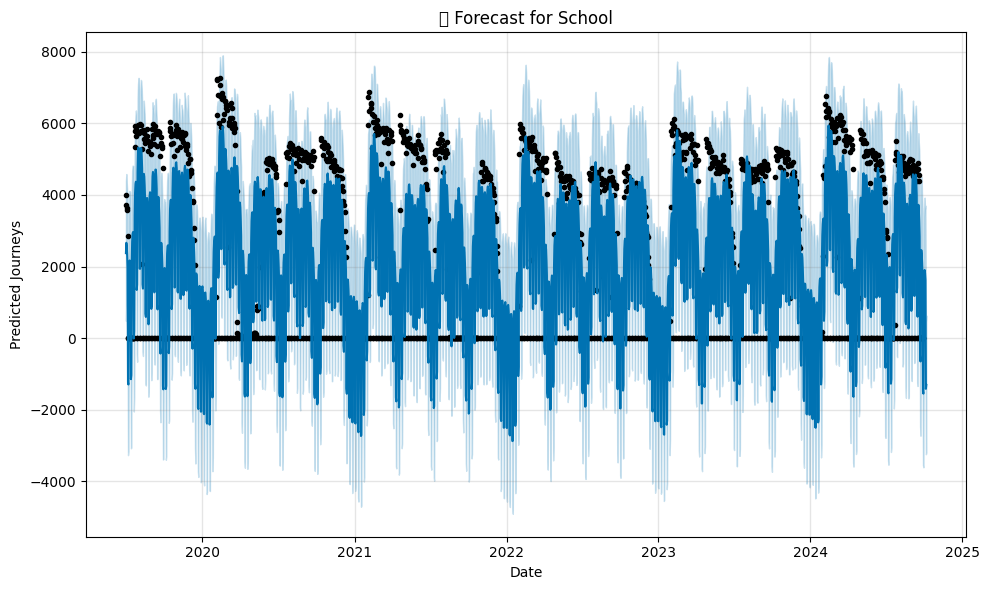

In [56]:
for service in service_columns:
    print(f"\n📈 Forecasting next 7 days for: {service.replace('_', ' ').title()}")

    non_null_count = df[service].dropna().shape[0]
    print(f"  Data points available: {non_null_count}")

    if non_null_count < 10:
        print(f"  ⚠️ Not enough data to forecast {service}. Skipping...")
        continue

    df_service = df[['Date', service]].rename(columns={'Date': 'ds', service: 'y'}).dropna()

    try:
        model = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='additive')
        model.fit(df_service)

        future = model.make_future_dataframe(periods=7)
        forecast = model.predict(future)

        forecast_7day = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
        forecast_7day.to_csv(f"{output_dir}/{service}_7day_forecast.csv", index=False)
        forecast_results[service] = forecast_7day

        fig = model.plot(forecast)
        plt.title(f"📉 Forecast for {service.replace('_', ' ').title()}")
        plt.xlabel("Date")
        plt.ylabel("Predicted Journeys")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"  ❌ Error forecasting {service}: {e}")


###Updated with predicted numerical values  + visualization

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/2mpu67yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/kp7x3ray.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75349', 'data', 'file=/tmp/tmpydkgb4r9/2mpu67yn.json', 'init=/tmp/tmpydkgb4r9/kp7x3ray.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_modelhxr4a6rq/prophet_model-20250527062127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Local Route


06:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📋 7-Day Forecast for Local Route:
           Date  Predicted_Local_Route
1917 2024-09-30           10566.645044
1918 2024-10-01           12363.087891
1919 2024-10-02           12528.864829
1920 2024-10-03           12379.863104
1921 2024-10-04           11845.520039
1922 2024-10-05            2705.395661
1923 2024-10-06            1781.798685


<ipython-input-57-64905c3667f1>:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


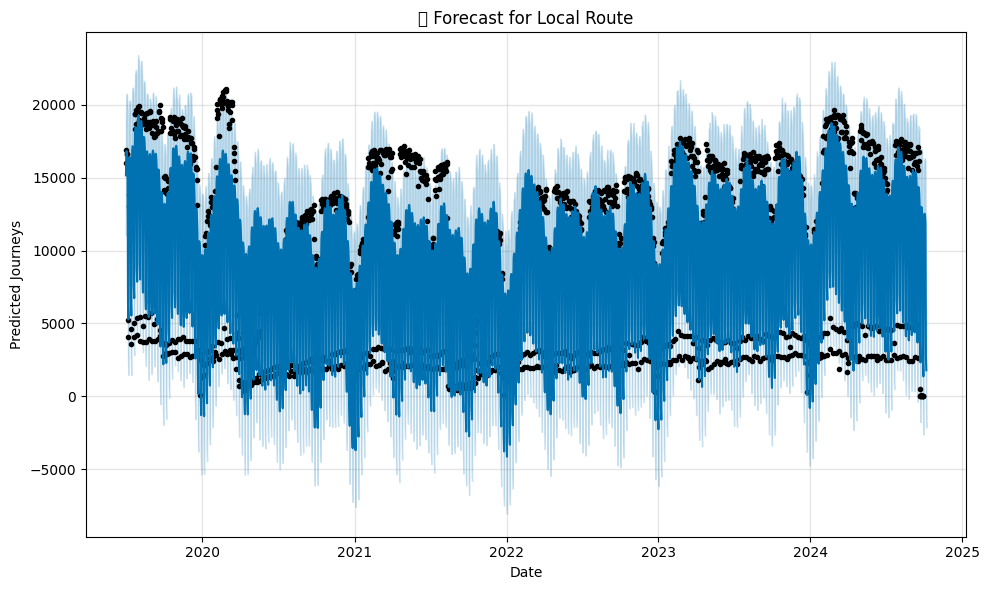

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/8oxj70wl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/h_jcqyb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51728', 'data', 'file=/tmp/tmpydkgb4r9/8oxj70wl.json', 'init=/tmp/tmpydkgb4r9/h_jcqyb4.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_modelwzggq4ia/prophet_model-20250527062129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Light Rail


06:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📋 7-Day Forecast for Light Rail:
           Date  Predicted_Light_Rail
1917 2024-09-30           7578.941318
1918 2024-10-01           8633.097205
1919 2024-10-02           8675.998824
1920 2024-10-03           8595.659523
1921 2024-10-04           8623.616770
1922 2024-10-05           5162.416134
1923 2024-10-06           3805.094949


<ipython-input-57-64905c3667f1>:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


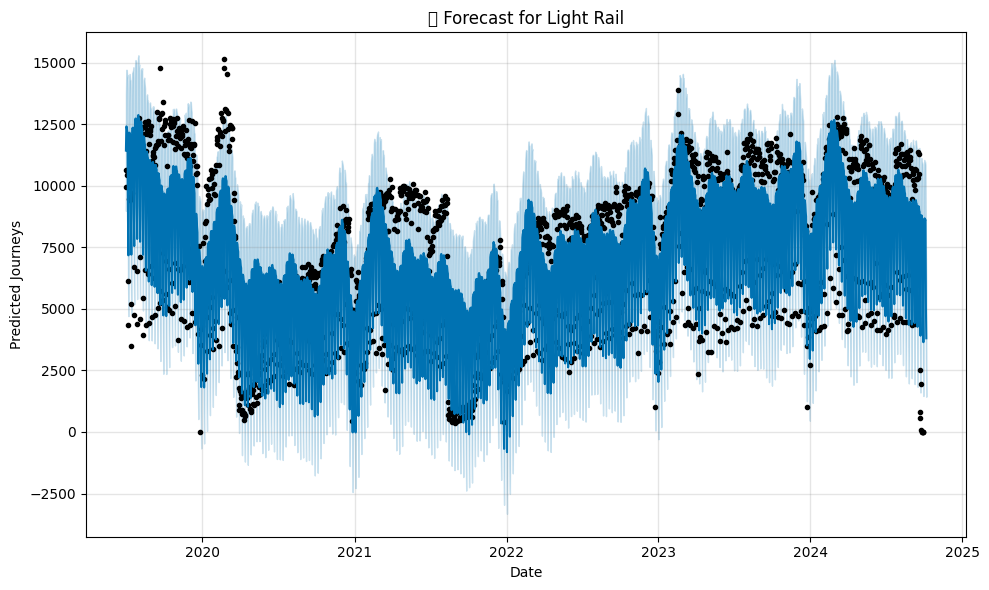

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/p8tamrkr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/nay842jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51670', 'data', 'file=/tmp/tmpydkgb4r9/p8tamrkr.json', 'init=/tmp/tmpydkgb4r9/nay842jb.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_model6xio6dy3/prophet_model-20250527062131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



📈 Forecasting next 7 days for: Peak Service


06:21:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📋 7-Day Forecast for Peak Service:
           Date  Predicted_Peak_Service
1917 2024-09-30              232.347780
1918 2024-10-01              277.974498
1919 2024-10-02              277.967284
1920 2024-10-03              251.670655
1921 2024-10-04              197.410047
1922 2024-10-05               -1.286892
1923 2024-10-06                0.412547


<ipython-input-57-64905c3667f1>:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


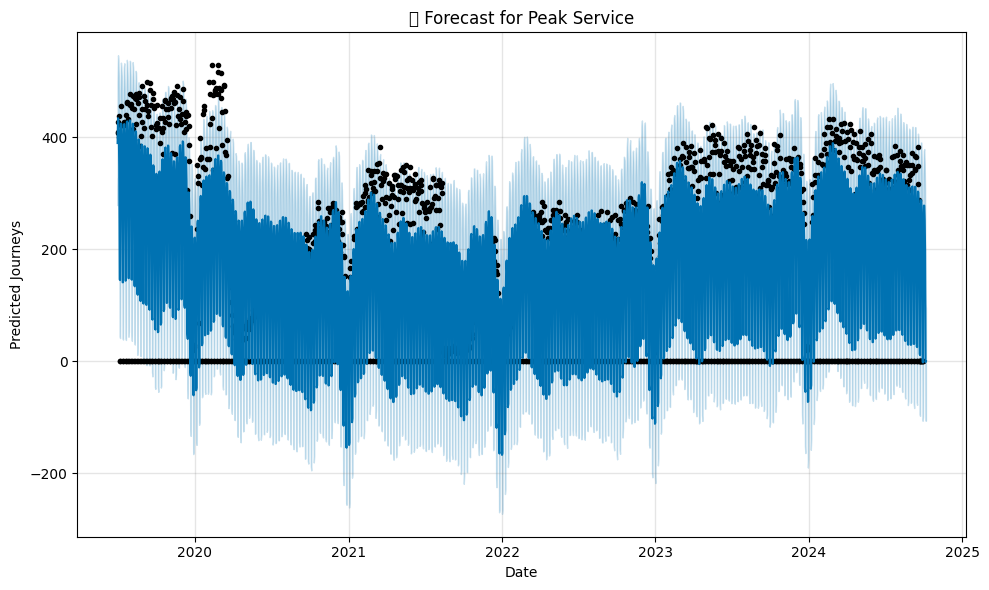

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/ybj9_m9k.json



📈 Forecasting next 7 days for: Rapid Route


DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/5l4urcja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52787', 'data', 'file=/tmp/tmpydkgb4r9/ybj9_m9k.json', 'init=/tmp/tmpydkgb4r9/5l4urcja.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_model2jbs8v90/prophet_model-20250527062132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📋 7-Day Forecast for Rapid Route:
           Date  Predicted_Rapid_Route
1917 2024-09-30           13397.398126
1918 2024-10-01           15503.213011
1919 2024-10-02           15589.011172
1920 2024-10-03           15398.500574
1921 2024-10-04           14685.259680
1922 2024-10-05            6503.580938
1923 2024-10-06            5053.458794


<ipython-input-57-64905c3667f1>:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


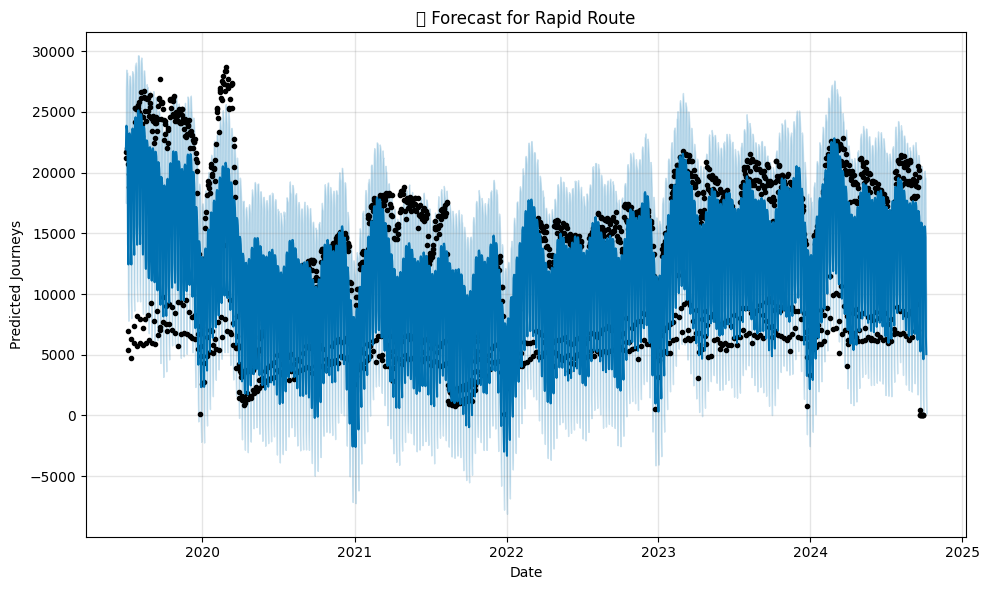

DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/jm9bon4i.json



📈 Forecasting next 7 days for: School


DEBUG:cmdstanpy:input tempfile: /tmp/tmpydkgb4r9/qsl2ixtd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64893', 'data', 'file=/tmp/tmpydkgb4r9/jm9bon4i.json', 'init=/tmp/tmpydkgb4r9/qsl2ixtd.json', 'output', 'file=/tmp/tmpydkgb4r9/prophet_modeldhvo9t_t/prophet_model-20250527062133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📋 7-Day Forecast for School:
           Date  Predicted_School
1917 2024-09-30       1418.206914
1918 2024-10-01       1842.397714
1919 2024-10-02       1903.028333
1920 2024-10-03       1805.528963
1921 2024-10-04       1621.504402
1922 2024-10-05      -1415.533623
1923 2024-10-06      -1307.012847


<ipython-input-57-64905c3667f1>:37: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


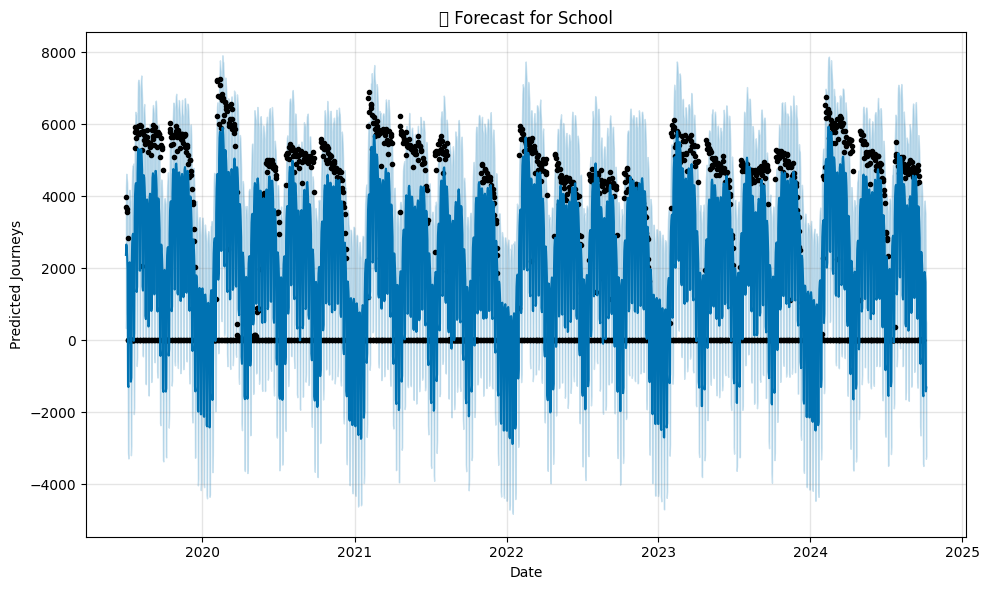


✅ All 7-day forecasts saved in 'forecast_output/' folder.


In [57]:

forecast_results = {}
output_dir = "forecast_output"
os.makedirs(output_dir, exist_ok=True)

for service in service_columns:
    print(f"\n📈 Forecasting next 7 days for: {service}")
    df_service = df[['Date', service]].rename(columns={'Date': 'ds', service: 'y'}).dropna()

    # Fit Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, seasonality_mode='additive')
    model.fit(df_service)

    # Make future dataframe
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    # Extract 7-day forecast
    forecast_7day = forecast[['ds', 'yhat']].tail(7)
    forecast_7day = forecast_7day.rename(columns={
        'ds': 'Date',
        'yhat': f'Predicted_{service.replace(" ", "_")}'
    })

    # Print forecast table
    print(f"\n📋 7-Day Forecast for {service}:")
    print(forecast_7day)

    # Save forecast to CSV
    forecast_7day.to_csv(f"{output_dir}/{service.replace(' ', '_')}_7day_forecast.csv", index=False)
    forecast_results[service] = forecast_7day

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f"📉 Forecast for {service}")
    plt.xlabel("Date")
    plt.ylabel("Predicted Journeys")
    plt.tight_layout()
    plt.show()

print("\n✅ All 7-day forecasts saved in 'forecast_output/' folder.")
